## Summary - Credit risk modelling using a Classification Model - Multimodel Analysis and Deployment

A clear and concise methodology for deciding whether a customer is approved for credit is essential for both the creditor and the customer. Inconsistencies within the system, which determine whether to approve or reject an application for credit, can lead to negative financial outcomes, both for customers and lending organisations. Firstly, approving credit to those who are likely unable to keep up with repayments can lead to defaulted payments, preventing future approvals of credit for the customer, and representing a loss of income for the organisation. Furthermore, from the perspective of a lender, defaulted customer payments can lead to reputational damage, with the lender potentially perceived as being irresponsible in its lending decisions. Conversely, a system that rejects customers who are highly likely to be able to repay in full also represents a lost fiscal opportunity for the lender and will likely drive the customer to a competitor.

Therefore, a system that is consistent and that considers the multifaceted aspects of a customer's financial background, current circumstances, and credit request is essential when deciding who should be eligible for credit and who should not. Machine learning algorithms are one of the key tools deployed across a breadth of industries for indicating approval or rejection of applications for credit. By ingesting historic data relating to customer attributes (features), the algorithm looks to examine if any patterns exist between the outcome of interest (in this case, credit acceptance) and these attributes. Using what it is learned from the historic data it has been trained on, the model can then attempt to indicate whether to accept of reject a new (unseen) application based on the information supplied by the customer.

The purpose of this project is to utilise Machine Learning, trained on historic data relating to customer credit applications, to predict from a series of unseen customer applications who should be approved and rejected for credit. These predictions will then be compared against the actual approval/rejection status of the customer to assess accuracy. This approach will be used for several variations of supervised machine learning models, with the performance of each model cross validated across a variety of evaluation metrics. The result of this process is an evidence-backed recommendation for which model would be best suited for deployment on new data. This model is then hyper-tuned for optimal performance, using parameter optimization techniques, and utilized to predict on unseen data, measuring performance against the non- Hypertuned model.

## Imported Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model Selection & Validation
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    RandomizedSearchCV
)

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics & Evaluation
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_auc_score,
)

# Feature Evaluation
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / "Data" / "Loan_approval_data_2025.csv"

df = pd.read_csv(DATA_PATH)

## Data Loading

Data loaded directly from CSV using Pandas read_csv function. The dataset is an open-source synthetic dataset curated using real banking criteria from US and Canadian financial institutions. This aligns with real-world patterns and relationships. The result is that this dataset is closer to an actual reflection of genuine application requests and their approval/rejection status compared against other synthetic datasets.

In [3]:
df.shape

(50000, 20)

The dataset contains 50000 rows and 20 columns. Each row represents an individual application. 50000 observations typically constitute a good sample size for machine learning algorithms, with 19 potential features presenting a good range to explore.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amount           

All datatypes match the requirements of the feature with no datatype adjustments needed. 

In [5]:
df.head(5)

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1


## Data Understanding

In [6]:
df['loan_status'].value_counts()

loan_status
1    27523
0    22477
Name: count, dtype: int64

The target feature is binary with one indicating an accepted application and zero indicating a rejected application. Value counts indicate a significant class imbalance.

In [7]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical_features].describe()

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.957060,7.454868,50062.892040,643.614820,8.168274,3595.619400,14290.442220,0.053480,0.55464,0.147640,33041.874000,15.498591,0.285724,0.701999,0.233995,0.550460
std,11.118603,7.612097,32630.501014,64.731518,7.207552,13232.399398,13243.757493,0.224991,0.84505,0.412996,26116.185102,4.067942,0.159787,0.465788,0.155268,0.497452
min,18.000000,0.000000,15000.000000,348.000000,0.000000,0.000000,60.000000,0.000000,0.00000,0.000000,500.000000,6.000000,0.002000,0.008000,0.003000,0.000000
25%,26.000000,1.300000,27280.500000,600.000000,2.000000,130.000000,5581.000000,0.000000,0.00000,0.000000,12300.000000,12.180000,0.161000,0.333000,0.111000,0.000000
50%,35.000000,4.900000,41607.500000,643.000000,6.100000,568.000000,10385.000000,0.000000,0.00000,0.000000,26100.000000,15.440000,0.265000,0.622000,0.207000,1.000000
75%,43.000000,11.400000,62723.250000,687.000000,12.600000,2271.000000,18449.250000,0.000000,1.00000,0.000000,48500.000000,18.870000,0.389000,1.010250,0.337000,1.000000
max,70.000000,39.900000,250000.000000,850.000000,30.000000,300000.000000,163344.000000,1.000000,9.00000,4.000000,100000.000000,23.000000,0.800000,2.001000,0.667000,1.000000


A large proportion of the features within the dataset are numerical. These represent quantitative elements of the application. These features 
display personal attributes of the applicant, historical details relating to the credit profile, and also details of the requested credit.

In [8]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_features].describe()

,customer_id,occupation_status,product_type,loan_intent
count,50000,50000,50000,50000
unique,50000,3,3,6
top,CUST100000,Employed,Credit Card,Personal
freq,1,34971,22455,12429


The categorical features within the dataset represent qualitative elements of the application. These attributes relate to personal aspects of the applicant (occupation status), and also details of the requested credit (product_type, loan_intent). As these features exist as objects (strings) within the dataset, they will require encoding before being interpretable by any of the classification models used within the scope of this project. 

Customer ID is a unique identifier for the customer application, and will be excluded as a feature in all models as it adds no benefit

In [9]:
pd.DataFrame({
    "Feature Type": ["Target", "Numerical", "Categorical"],
    "Count": [1, len(numerical_features), len(categorical_features)]
}).set_index('Feature Type')

,Count
Feature Type,
Target,1
Numerical,16
Categorical,4


Continuous variables constitue to the majority of predictor features, with 75% being continuous.

## Data Cleaning

In [10]:
df.duplicated().sum()

0

The dataset contains no duplicate values. This is important as duplicate values can distort model results. If duplicates did exist, they would require further investigation to establish if they could be removed or required transformation due to be a real world artifact reflected in the data. 

In [11]:
df.isnull().sum()

customer_id                0
age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64

The data contains no null values within any of the observations. This is also important as Machine Learning models typically cannot handle datasets with null values. If null values did exist, the null aspects would need examining to ascertain the most appropriate processing step (removal or imputation)

## EDA - Exploratory Data Analysis

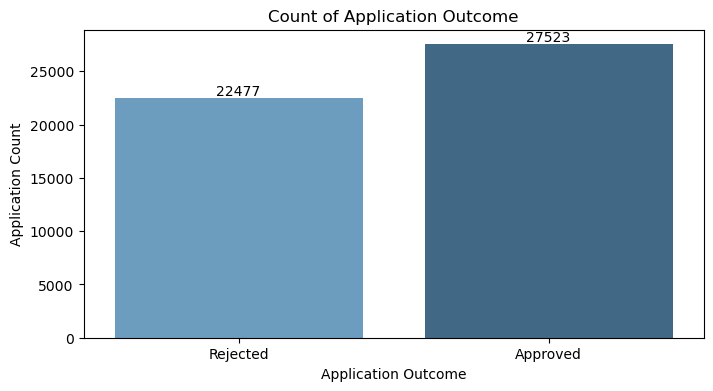

In [12]:
plt.figure(figsize=[8,4])
ax = sns.countplot(df, x='loan_status', palette='Blues_d')
plt.ylabel('Application Count')
plt.xlabel('Application Outcome')
plt.title('Count of Application Outcome')
ax.set_xticklabels(['Rejected', 'Approved'])
for container in ax.containers:
    ax.bar_label(container)
plt.show()

A countplot of application-approved/rejected status demonstrates a class imbalance of over 5000 fewer observations within the minority class. This can be potentially problematic for classification problems, as models can develop a bias toward selecting the majority class in predictions. The level of class imbalance observed within this dataset likely requires a resampling technique to prevent potential bias within model predictions. 

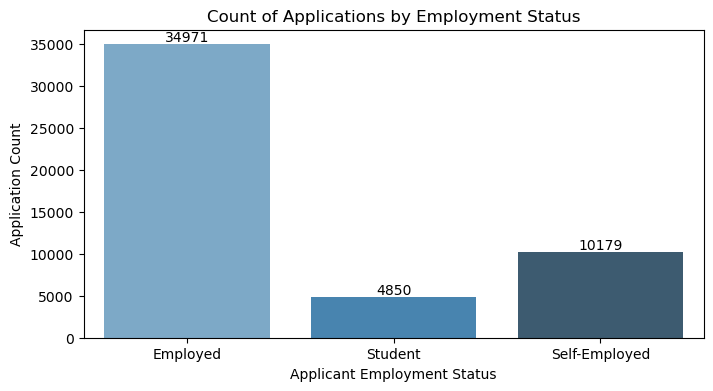

In [13]:
plt.figure(figsize=[8,4])
ax = sns.countplot(df, x='occupation_status', palette='Blues_d')
plt.ylabel('Application Count')
plt.xlabel('Applicant Employment Status')
plt.title('Count of Applications by Employment Status')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

Countplot of applications broken down into employment status indicates a clear overrepresentation of applicants with an occupational status of Employed within the dataset. As this feature is not the target variable, no resampling technique is required.

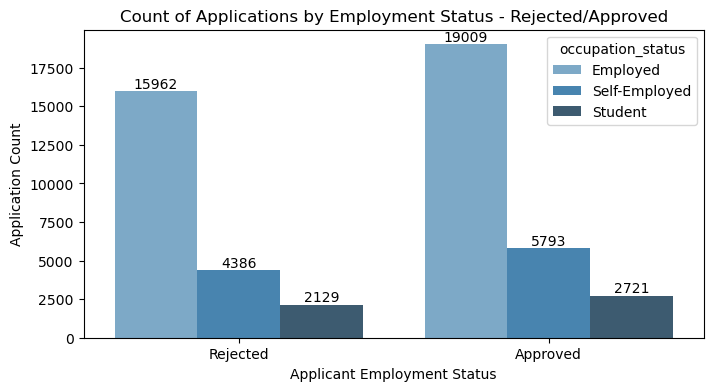

In [14]:
plt.figure(figsize=[8,4])
ax = sns.countplot(df, x='loan_status', hue='occupation_status', palette='Blues_d')
plt.ylabel('Application Count')
plt.xlabel('Applicant Employment Status')
ax.set_xticklabels(['Rejected', 'Approved'])
plt.title('Count of Applications by Employment Status - Rejected/Approved')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

The representation of each employment group remains consistent with the entire dataset when examining by loan status.

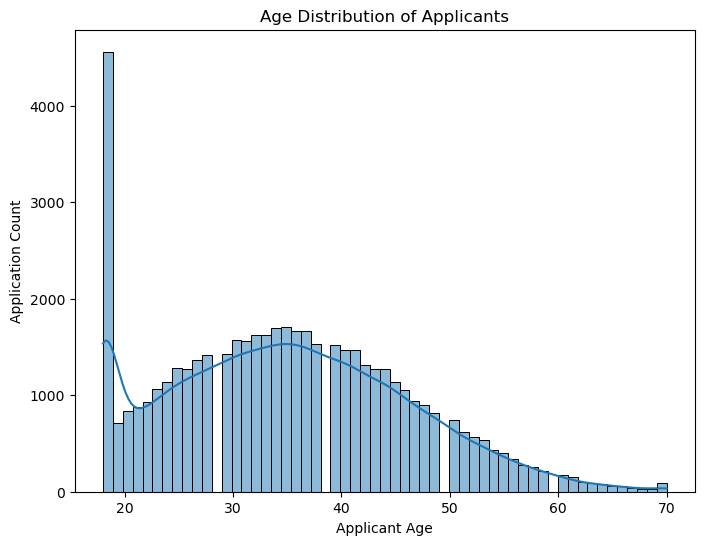

In [15]:
plt.figure(figsize=[8,6])
ax = sns.histplot(df, x='age', palette='Blues_d', kde=True)
plt.ylabel('Application Count')
plt.xlabel('Applicant Age')
plt.title('Age Distribution of Applicants')
plt.show()

The distribution of applicant age almost demonstrates almost normal distribution; however, extreme right skew exists, due to high volume within the 18 year old bracket. This skew will require consideration if any techniques used make normality assumptions and use this feature. 

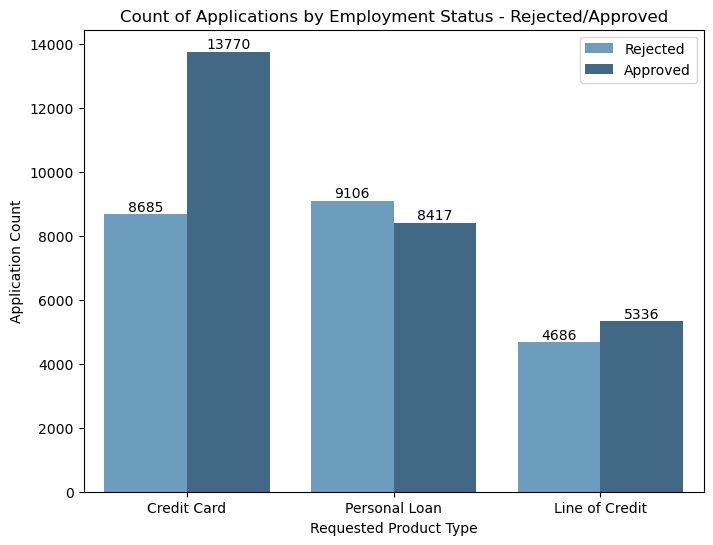

,Acceptance Rate
product_type,
Credit Card,0.61
Line of Credit,0.53
Personal Loan,0.48


In [16]:
plt.figure(figsize=[8,6])
ax = sns.countplot(df, x='product_type', hue='loan_status', palette='Blues_d')
plt.ylabel('Application Count')
plt.xlabel('Requested Product Type')
plt.title('Count of Applications by Employment Status - Rejected/Approved')
ax.legend(['Rejected', 'Approved'])
for container in ax.containers:
    ax.bar_label(container)
plt.show()

df_pivot = pd.pivot_table(data=df, values='customer_id', columns=['loan_status'], index=['product_type'], aggfunc='count').rename(columns={0:'Rejected', 1:'Accepted'})
df_pivot['Acceptance Rate'] = df_pivot['Accepted']/(df_pivot['Rejected'] + df_pivot['Accepted'])
pd.DataFrame(df_pivot['Acceptance Rate']).round(2)

When examining the application outcome, split by requested product, it appears that credit cards have a higher acceptance rate than other products. With just over 60% of credit card applications being accepted, compared to 53% for Line of Credit, and less than 50% for personal loans. 

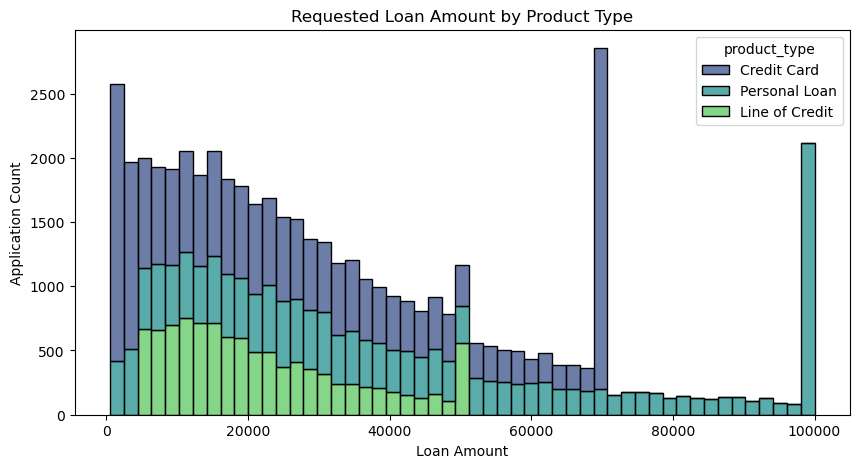

,median,mean,max
,loan_amount,loan_amount,loan_amount
product_type,,,
Credit Card,24200,29263,70000
Line of Credit,18700,21862,50000
Personal Loan,36900,44278,100000


In [17]:
plt.figure(figsize=[10,5])
ax = sns.histplot(df, x='loan_amount', palette='viridis', hue='product_type', multiple = 'stack')
plt.ylabel('Application Count')
plt.xlabel('Loan Amount')
plt.title('Requested Loan Amount by Product Type')
plt.show()

pd.pivot_table(data=df,index='product_type', values='loan_amount', aggfunc=['median', 'mean', 'max']).astype(int)

Loan amount expanded by product type reveals that line of credit typically has the lowest range of requested amount, whereas personal loans have the highest range of requested loan amount. All product types demonstrate the largest volumes of requested ammount, at the max available of each product type. 

Descriptive statistics display a similar pattern, with personal loan having both the highest median, mean, and max, whereas line of credit is the lowest, for all three respective statistics. Credit card, which represents the majority class of product type, has closer values to a line of credit than a personal loan.

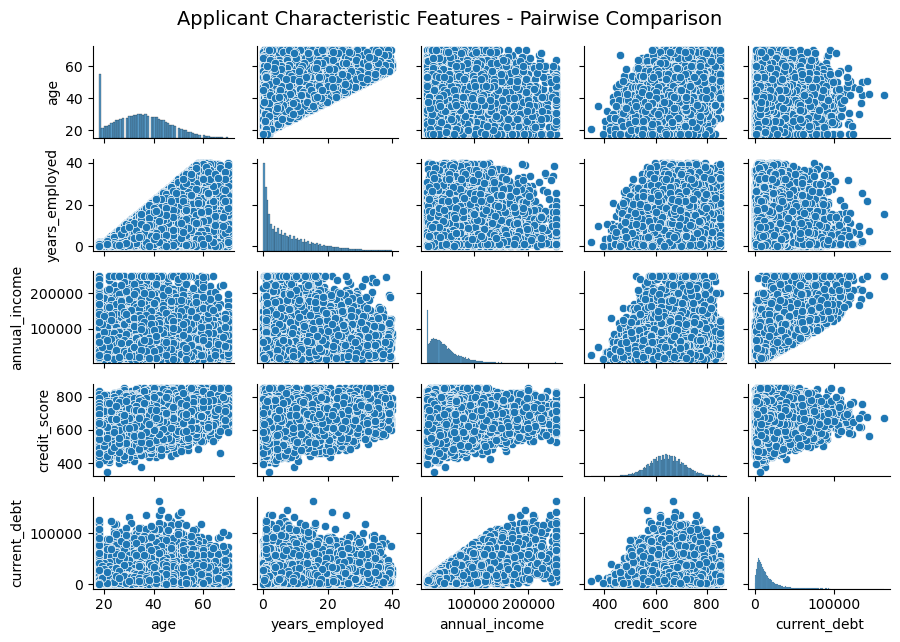

In [18]:
scatter_vars = df[['age', 'years_employed', 'annual_income', 'credit_score', 'current_debt']]

sns.pairplot(scatter_vars, height=1.3, aspect=1.4)
plt.suptitle('Applicant Characteristic Features - Pairwise Comparison',
             fontsize=14)
plt.tight_layout()

Pairwise comparison shows slight multicollinearity between some of the Features that represent Applicant characteristics. Age and Years employed demonstrate a clear linear relationship; however, this is an anticipated artifact of the data. Current debt and annual income appear to demonstrate a linear relationship. Credit score and years employed show some correlation but the relationship does not appear as linear as debt and income. All other variables demonstrate minimal to no relationship.

## Feature Engineering

In [19]:
categorical = ['occupation_status', 'product_type', 'loan_intent']
df_encoded = df[categorical]
df_encoded = pd.get_dummies(df_encoded, columns=categorical, dtype=int)
df = pd.concat([df,df_encoded], axis = 1).drop(columns=categorical)

Occupation status, product type, and loan intent require conversion from qualitative categorical features to binary values in order to examine correlation with other features, and also for potential selection in classification models. This is essential as traditional Machine Learning models are unable to interpret categorical features represented as strings. However, this engineering step does add additional features to the model and will need to be factored in when considering model complexity. 

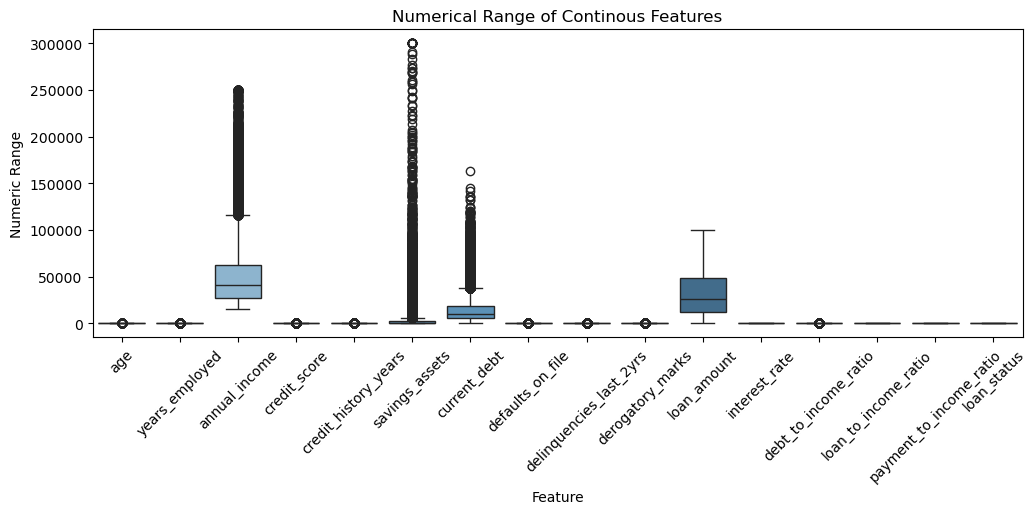

In [20]:
plt.figure(figsize=[12,4])
sns.boxplot(df[numerical_features], palette='Blues_d')
plt.title('Numerical Range of Continous Features')
plt.xlabel('Feature')
plt.ylabel('Numeric Range')
plt.xticks(rotation=45)
plt.show()

Box plots of the numeric range of all continuous features reveal a wide degree of variance between each individual variable. As the models included within the project are distance based, scaling will need to be applied. This requirement will need to be performed after splitting into training and testing datasets, to prevent data leakage.

## Feature Selection

In [21]:
X = df.drop(columns=['loan_status', 'customer_id'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1111)

In [22]:
train_count = len(X_train)
test_count = len(X_test)
pd.DataFrame({'Dataset' : ['Training Observations', 'Testing Observations'],
             'Count' : [train_count, test_count]}).set_index('Dataset') 

,Count
Dataset,
Training Observations,40000
Testing Observations,10000


The entire dataset was split into separate training and testing datasets using an 80/20 split. This split was utilised for all models in the project. Due to the large number of observations, this was deemed to be an adequate split, providing a balance between having ample observations to train the model on and a large enough volume of testing observations to validate model predictions on. 

The split was intentionally applied prior to correlation analysis and feature selection to prevent data leakage. For context, data leakage is where the model is unintentioally exposed to any of the testing data which is supposed to be unseen. This can influence the models predictions, and lead to an inflated level of accuracy, due to the model predicting on data it has in fact already seen. 

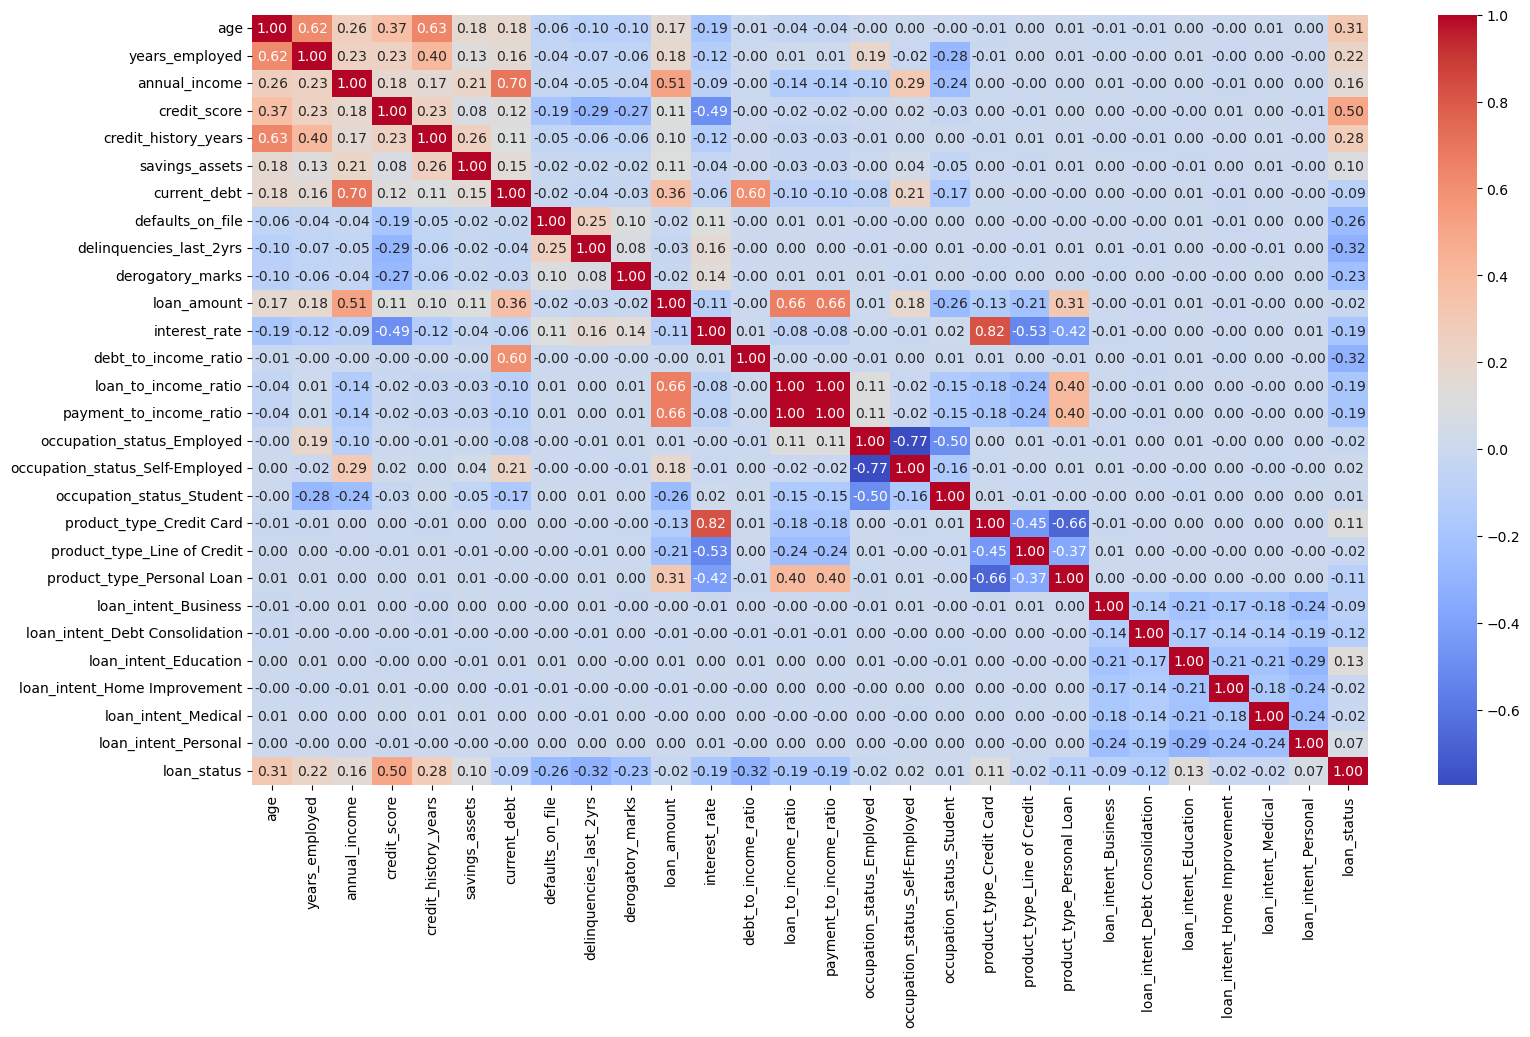

In [23]:
y_train = y_train.squeeze()  
df_train = pd.concat([X_train, y_train], axis=1)

df_num = df_train.select_dtypes(include='number')

plt.figure(figsize=[18,10])
matrix = df_num.corr()
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

To reduce model complexity, and exclude features that do not appear to have a relationship with the target variable, a threshold of 0.2 was set to exlude any features that had less than 0.2 (positive or negative) correlation coefficient with the target variable.

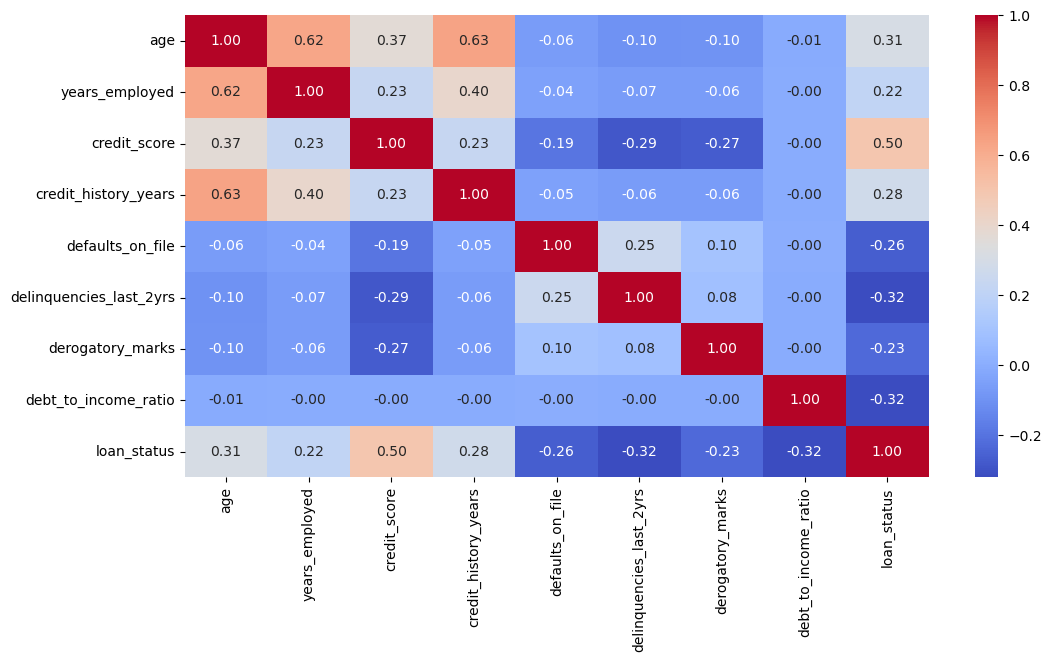

In [24]:
corr_with_target = matrix['loan_status']

selected_features = corr_with_target[abs(corr_with_target) > 0.2].index.tolist()

df_train = df_train[selected_features]

plt.figure(figsize=[12,6])
matrix = df_train.corr()
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [25]:
corr_with_target = corr_with_target[selected_features]

Feature_Table = (pd.DataFrame(corr_with_target)
 .rename(columns={'loan_status':'Feature Coeffictient'})
 .iloc[ : -1]
 .sort_values(by='Feature Coeffictient', ascending =False))

After removing all features that did not meet the specified alpha for correlation coefficient the remaining variables where:

In [26]:
Feature_Table

,Feature Coeffictient
credit_score,0.496511
age,0.307823
credit_history_years,0.276778
years_employed,0.215459
derogatory_marks,-0.229861
defaults_on_file,-0.264413
debt_to_income_ratio,-0.317153
delinquencies_last_2yrs,-0.320438


Of the encoded features, none of the categorical features reached this threshold, so they were also excluded. All remaining features, excluding the binary target, where continuous. 

The training and testing feature dataframes where then filtered to only include the features that exceeded r of 0.2. This was performed on the original dataframe rather than re-applying the split to ensure that features have only been selected based upon the original training hold-outs.

## Model Selection & Cross Validation

In [27]:
selected_features.remove('loan_status')

X_test = X_test[selected_features]
X_train = X_train[selected_features]

In [28]:
scaler = StandardScaler()

Due to the variable ranges of the feature and the fact that some of the models included within this project use distance-based algorithms, feature scaling was required. For this project, the StandardScaler method was applied from Scikit-Learn's Preprocessing library. This technique effectively takes all features it is exposed to, and adjusts the means of each feature to zero and the standard deviations to one.  

Standard scaler was initiated, and was fit_transformed as part of the pipeline, to ensure the scaling was applied to each fold of the cross validation, but only on the training dataset.   

In [29]:
models = {"Logistic Regression": LogisticRegression(max_iter=1000, random_state=42), 
          "KNN": KNeighborsClassifier(n_neighbors=5), 
          "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10),
          "XGBoost" : XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss',
            random_state=42
    )
}
scoring = {'Accuracy': 'accuracy', 
            'Precision':'precision', 
            'Recall':'recall', 
            'f1_Score':'f1',
            'ROC_AUC': 'roc_auc'
          }

Four models were instantiated. The four models selected were picked due to the target variable being binary, and therefore the overaching scenario (Credit approval/rejection) to be considered a classification problem. The models selected represent a range of different classification techniques, allowing for comparisons to not only examine different model types, but also different classification techniques. 

The models included the following:

* Logist Regression - Classic linear baseline model. Easy for interpretation, and a good baseline classifier.

* KN Neighbours - Non-Parametric, instance based, lazy learner. Offers an example of a different type of classifier (Simple and Versatile).

* Random Forest Classifier - Ensemble Method, reduced risk of overfitting, and can offer insight into impact of features.

* XGBoost - Typically outperforms compartive models on classification taks. Allows for regularization and also reduces the risk of overfitting.

The five evaluation methods deployed offer a broad selection of metrics to examine model performance. 

The metrics used were:

* Accuracy - The standard baseline metric for classification models. Good for an overview of the model performance, although doesnt indicate model prediction strengths.
    
* Precision - Provides a measure of the models ability for correctly predicting positive classes, with minimal false positives. This is demonstrated by a high rate of true positives.
    
* Recall - Gives an indication of the models ability to correctly predict the majority of postive cases. This is represented by low numbers of false negatives.
    
* F1 - Provides a combined overview of Precision and Recall, allowing for an overall Precision, Recall peformance metric, and a way to generalise the models overall classification performance.
    
* ROC - Demonstrates a models performance against a random benchmark of only positive predictions. Indicates how well a model can distinguish between positive and negative cases.

The variety of perfomance metrics allows for comparitive analysis to be measured across a number of models, with the statisics providing a quantifiable output in which to find the best model to select for deployment. 

The hyperparameters used for each model were reflective of typical default or starter values. No model was unequally optimised in comparison to the others, with model optimisation being deployed after comparing all models, and selecting the most appropriate for this task.

In [30]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

results = {}

for name, model in models.items():

    pipeline = Pipeline([
        ('scaler', scaler),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    cv_results = cross_validate(
        pipeline, X_train, y_train, cv=kf,
        scoring=scoring,
        n_jobs=-1
    )
    
    results[name] = {metric: cv_results[f'test_{metric}'].mean()
                     for metric in scoring.keys()}

A stratified cross-fold of five splits was instantiated. Considering the number of observations, five splits were deemed ample, with a shuffle applied to ensure randomness and reduce overfitting in the model by disrupting any artifacts in the order of the data. 

The instatiated pipeline consisted of the scaler for scaling the range of features for better model interpretation, SMOTE to negate the class imbalance within the target variable, and then the model this pipeline was deployed on. 

Finally, the results of each model were cross validated across five folds to generate a more generalised score for each model. 

In [31]:
results = pd.DataFrame(results)  
results.style.highlight_max(axis=1,color='lightgreen').highlight_min(axis=1,color='lightblue')

,Logistic Regression,KNN,Random Forest,XGBoost
Accuracy,0.816525,0.821725,0.854850,0.856450
Precision,0.838908,0.840283,0.865709,0.866014
Recall,0.825218,0.834848,0.871503,0.874546
f1_Score,0.831962,0.837526,0.868587,0.870245
ROC_AUC,0.901952,0.891000,0.934679,0.936653


As can be seen across all five evaluation metrics, the XGboost outperforms all other models. It demonstrates a higher level of overall accuracy, a greater propensity for accurately predicting positive classes and the lowest rate of incorrectly predicting positive classes. The XGboost demonstrating the highest F1 score is further evidence of the models exeptional ability at both precision and recall. In summary, the model excels at correctly predicting the positive class with confidence (reflected by the high recall rate i.e. less false positives). The fact that the model also displays the highest ROC_ACU is further demonstration of this, showcasing the models ability to correctly distinguish between positive and negative classes. 

Compared against both Logistic Regression and KNN, XGboost demonstrates between 3 and 5% better performance. Interestingly however, this increase in performance is substantially less, when compared to the Random Forest Classifier (RFC), with the XGboost typically demonstrating only a 1% postive variance across all metrics. Considering the four models used, and the comparitive performance, this would indicate that tree based classifiers are the most suitable for this particual classification task. It is worth noting that the marginal outperformance of the XGboost compared to the RFC comes at the cost of a more complex algortym. Therefore further investigation could potentially involve optimising the RFC to see if it can match/outperform the XGboost, allowing for a less complex Machine Learning approach to be used, with the same results.

Logistic Regression performed the worst of the models across all metrics except the ROC_AUC, where KNN demonstrated the lowest score. This poor comparitve perfomance may be a reflection of the simplistity of the Logistic Regressions algorythm, as it appears to be less able to extract patterns within the training set and generalise this to unseen data than the other models. The low ROC_AUC of the KNN could potentially be a result of this particular models sensisitivity to noise within the dataset, leading to the model perfoming worse at distinguishing positive and negative classes. One potential cause of this noise could be the low level of correlation some of the selected features displayed, with some features only demonstrating a weak correlation coefficent. These features potentially add unsesseary noise into the model for KNN. As KNN is a distance based model, features that are not truely relevant in the context of the target can influence the distance alogorythm KNN uses, and inadvertantly influence the predictions. An increase in aplha for feature selection could potentially lead to better ROC_AUC in this particular model. Alterntively, an examination of feature importance for the KNN model, and then refitting the model only with the most relevant features could lead to better performance. However, it is to be noted that this could potentially lead to further reduction in features, and leading to a model which is too simplistic.   

Based on the XGboosts ability to outperform all other models, across all metrics, it was detremined that this was the best model to select for Hyperparameter tuning. It is worth noting however, that the Random Forest Classifier may also be an adequate Machine Learning Model for this particular classification task, based upon its near compartive performance to the XGboost.

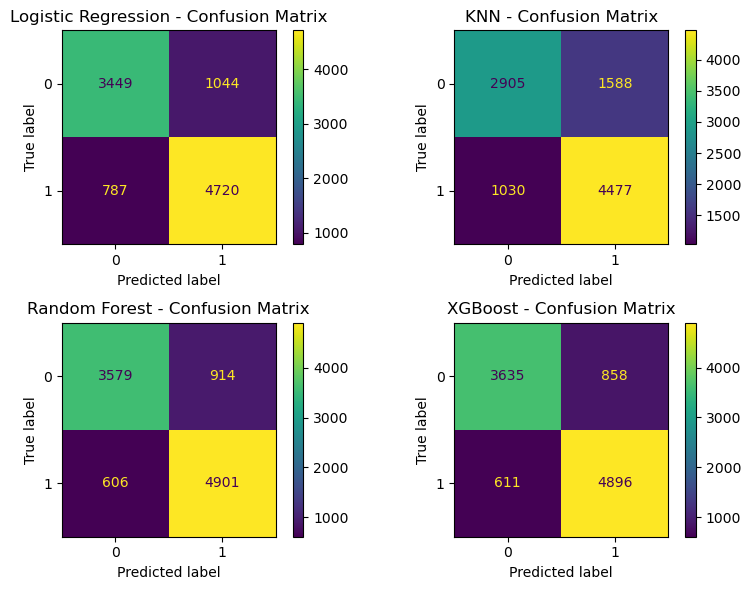

In [32]:
fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for ax, (name, model) in zip(axes, fitted_models.items()):
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")

plt.tight_layout()
plt.show()

The confusion matrix displays the XGBoost predictive ability compared to other models. As shown, the model correctly classified the most negative classes and had the lowest number of false positives. Furthermore, compared to the RFC, which made the highest number of correct postive classifications, the XGboost only incorrectly predicted five less positive cases that where actually negative cases. Comparatively, the XGBoost correctly predicts True negatives in 56 more instances than the RFC, and false positives in 56 fewer instances compared to the RFC.

Comparing the models on this level of granularity, the confusion matrix indicates that the XGBoost is likely the best model for this task. Taking into account the context of the risks associated with incorrectly accepting or rejecting credit, a model that is the best at correctly indicating when to reject a credit application is the one that arguably carries the lowest financial risk for the lender. This, paried with the almost identical performance of the Xgboost compared to the RFC model for correctly indicating when to accept an applications demonstrates a model that can balance risk aversion, with accepting the correct candidates for credit.

After carefully examining the evaluation metrics and the strengths and limitations of each model, the final model for deployment selected for Hyperparameter tuning was the XGBoost. This selection was not purely on the basis of its superior performance, but also its proponsity to be significantly better at predicting negative classes (and therefore carries less risk) than other models. Overall, the XGBoost demonstrates a strong balance of superior performance across a breadth of evaluation metrics, and also is the best suited for this particualr buisness case.

## Hyperparameter Tuning

In [33]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )
    )
])

param_dist = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.001, 0.01],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_cv = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,     
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
xgb_cv.fit(X_train, y_train)

# Best results
print("Best params:", xgb_cv.best_params_)
print("Best model:", xgb_cv.best_estimator_)
print("Best score:", xgb_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}
Best model: Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,

For hyperparameter tuning, a Pipeline containing the SMOTE resampling technique and the instantiated XGBoost model with a logloss configuration was created. Standard scaling was not included, as this is not required for XGBoost models. When considering the potential computational cost of hyperparameter optimizing techniques, a Randomized Search CV was chosen in favour of a Grid Search CV.

A series of arrays with a range of parameter combinations was stored in a dictionary. Once again, due to the computational cost of hyperparamter tuning cross validation, the maximum number of estimators to search was 200, and the maximum depth of the model was five. The model learning rate, model sample per tree, and column sample per tree were also included within the dictionary, with each parameter's own respective array. Although the values of each parameter do not represent the maximum values that XGboost can select, it was deemed to still offer an adequate range of parameters to perform hyperparameter tuning. F1 score was selected as the evaluation metric, as this offers the best objective summary of both performance and recall within the same metric, without the ambiguity that comes with an accuracy score.

With a dictionary of 12 hyperparameter values, across five hyperparamters the final result was 60 fits for corss validation. Fitting the Random Search CV XGboost model to the training data, the best performing model produced an F1 score of 0.87. This is an identical F1 to the non-optimised XGBoost.

In [34]:
best_pipeline = xgb_cv.best_estimator_

best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:,1]

results_train = pd.DataFrame({'Metric' : ["Accuracy", "Precision", "Recall", 'f1_Score', 'ROC_AUC'],
                              'XGB Hyperparameter Tuned' : [accuracy_score(y_test, y_pred),
                                         precision_score(y_test, y_pred),
                                         recall_score(y_test, y_pred),
                                         f1_score(y_test, y_pred),
                                         roc_auc_score(y_test, y_pred_proba)
                                                     ]}
                            )

results_train.set_index('Metric', inplace=True)

cv_results = results.iloc[:, [3]]
results_compt = pd.concat([cv_results, results_train], axis=1).rename(columns={'XGBoost': 'XGB Untuned'})

Using Randomized Cross Validations best_estimator outputs, this was then fit to the training data, with performance observed across identical evaluation metrics to those used on earlier model selection. 

In [35]:
results_compt['Variance'] = round(results_compt['XGB Hyperparameter Tuned'] - results_compt['XGB Untuned'], 2)
results_compt['Percentage Diff'] = round(100 * (results_compt['XGB Hyperparameter Tuned'] - results_compt['XGB Untuned'])/ results_compt['XGB Untuned'], 2) 
results_compt.style.highlight_max(axis=1,color='lightgreen', subset = ['XGB Hyperparameter Tuned', 'XGB Untuned'])

,XGB Untuned,XGB Hyperparameter Tuned,Variance,Percentage Diff
Accuracy,0.856450,0.848300,-0.010000,-0.950000
Precision,0.866014,0.869308,0.000000,0.380000
Recall,0.874546,0.852733,-0.020000,-2.490000
f1_Score,0.870245,0.860941,-0.010000,-1.070000
ROC_AUC,0.936653,0.932970,-0.000000,-0.390000


Interestingly, the comparison between the tuned and untuned models revealed that, in general, performance was actually better using the untuned model. With the exception of precision, which demonstrated a minimal improvement, the untuned model displayed higher scores across all other metrics. The largest variance was observed for recall, where the untuned model demonstrated 2.5% better recall than the tuned model.

Although the hyperparameter tuning appears somewhat ineffective, it does go some way to showcasing that the default hyperparameters selected for the untuned XGBoost were likely optimal. Additionally, the similarity in performance between both tuned and untuned models provides further indication of the model's superior generalisation ability and lack of overfitting. Further performance increases within the XGBoost model are likely to be driven by feature availability, rather than hyperparameter tuning. Providing additional, meaningful features to the dataset could potentially provide even greater performance increases.

## Feature Importance & Permutation Importance

In [36]:
final_xgb_pipeline = Pipeline([
    ('scaler', scaler),
    ('model', models['XGBoost'])
])

final_xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

To compare the feature importance of both the tuned and untuned model, it was required to extract each model from its respective pipeline. 

In [37]:
XGB_Model_untuned = final_xgb_pipeline.named_steps['model']
XGB_Model_tuned = best_pipeline.named_steps['model']

booster_untuned = XGB_Model_untuned.get_booster()
booster_tuned = XGB_Model_tuned.get_booster()

importance_gain_untuned = booster_untuned.get_score(importance_type='gain')
importance_gain_tuned = booster_tuned.get_score(importance_type='gain')

In [38]:
feature_importance_untuned = (
    pd.DataFrame(importance_gain_untuned.items(), 
                 columns=['Feature', 'Untuned Model']))

feature_map = X_train.columns

feature_importance_untuned['Feature'] = feature_map[
   feature_importance_untuned['Feature'].str.replace('f', '').astype(int)
].values

feature_importance_tuned = (
    pd.DataFrame(importance_gain_tuned.items(),
                 columns=['Feature', 'Tuned Model']))

importance_df = pd.concat([feature_importance_untuned, feature_importance_tuned], axis = 1).iloc[:, [0,1,3]]

importance_df['Untuned Model'] = importance_df['Untuned Model'] / importance_df['Untuned Model'].sum()
importance_df['Tuned Model'] = importance_df['Tuned Model'] / importance_df['Tuned Model'].sum()
importance_df

,Feature,Untuned Model,Tuned Model
0,age,0.034039,0.058095
1,years_employed,0.021065,0.022981
2,credit_score,0.184128,0.472877
3,credit_history_years,0.049648,0.067290
4,defaults_on_file,0.341501,0.081935
5,delinquencies_last_2yrs,0.143370,0.057439
6,derogatory_marks,0.103886,0.037327
7,debt_to_income_ratio,0.122363,0.202055


Text(0.5, 0, 'Model Feature')

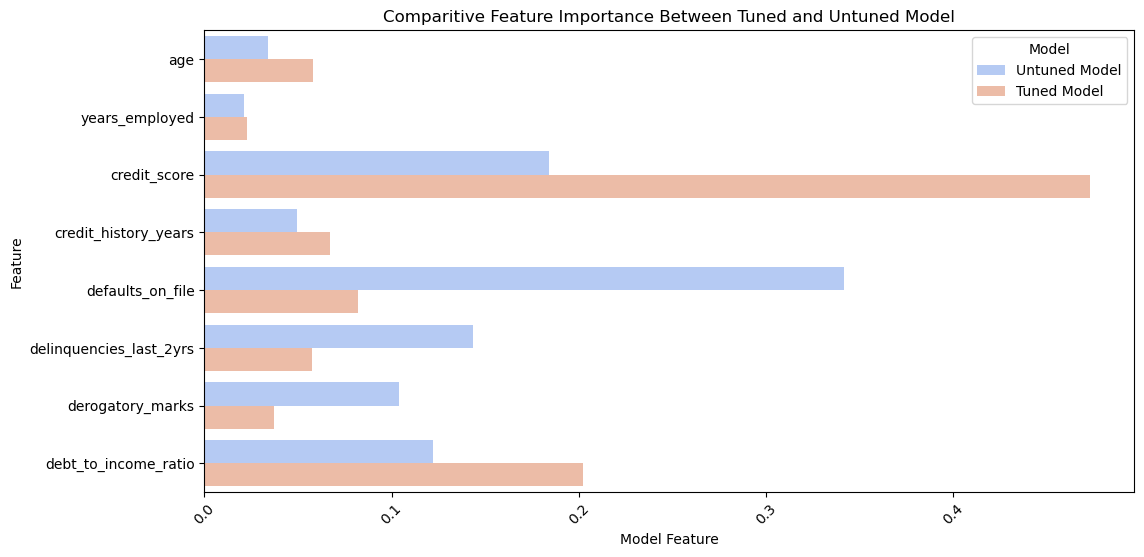

In [48]:
importance_df_long = importance_df.melt(
    id_vars='Feature',
    value_vars=['Untuned Model', 'Tuned Model'],
    var_name='Model',
    value_name='Importance'
)

plt.figure(figsize=[12,6])
sns.barplot(data=importance_df_long, x='Importance', y='Feature', hue='Model', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparitive Feature Importance Between Tuned and Untuned Model')
plt.xlabel('Model Feature')

For comparative feature evaluation, feature gain was used as an evaluation metric. Although this metric does not imply a causal effect or the direction of feature impact, it does indicate which features the model uses the most to improve performance. In summary, gain examines the error before and then after a model splits using a specific feature. The positive variance (improvement) is the gain. If a feature is used frequently, this gain is typically greater than for a feature that is not used often. Consequently, a larger gain score indicates a feature that the model uses a lot to increase predictions, compared to those with a lower gain score.

Comparing the feature importance of both models, the tuned model relies heavily on credit score for loss reduction, accounting for 47% of feature importance for this particular model. Whereas the untuned model was more reliant upon defaults on file, with 34% of total importance in that model. In the context of the tuned model, this means that for almost half of the time, the model improved performance, and the credit score was used. Conversely, for the untuned model, over a third of model performance improvements were driven by the defaults on file feature.

The key difference revealed by comparative feature importance between the two models is that the untuned model has a propensity for using binary features for improving model performance (defaults on file and delinquencies in the last 2 years ranking first and third), whereas the tuned model favours continuous features for performance improvement (credit score and debt to income ratio ranking first and second).

Credit score is ranked in the top three for both models, indicating that, irrespective of the hyperparameters used in either model, credit score has a significant contribution to improving XGBoost performance.

In [50]:
result_untuned = permutation_importance(
    final_xgb_pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1'  # or your metric
)

result_tuned = permutation_importance(
    best_pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="f1"
)

df_perm = pd.DataFrame({
    'Feature': X_test.columns,
    'Untuned Model': result_untuned.importances_mean,
    'Tuned Model': result_tuned.importances_mean
})

df_perm

,Feature,Untuned Model,Tuned Model
0,age,0.004116,-0.001899
1,years_employed,0.005343,-0.000527
2,credit_score,0.114399,0.165911
3,credit_history_years,0.028457,0.021395
4,defaults_on_file,0.030362,0.030192
5,delinquencies_last_2yrs,0.027359,0.020979
6,derogatory_marks,0.004858,0.000407
7,debt_to_income_ratio,0.099795,0.093238


Despite feature gain being able to indicate which features the model uses the most to improve predicitve performance, this technique does lack interpretability in the context of the predictive impact of each feature. To counteract this, permutation importance was used as an evaluation metric. 

Unlike feature gain, permutation performance is an examination of the drop in predictive accuracy (in this case, f1 score), if a feature is randomly shuffled. For permutation importance, larger values signify a greater drop in the selected evaluation metric, and thus indicate the impact this feature is having on the models predictive performance. Conversely, large negative values indicate noise within the model, and can potentially suggest features that are typically not contributing to model predictive performance. 

In accordance with feature gain, credit score, debt-to-income ratio, and defaults on file represented the top three features that demonstrated the greatest drop in f1 score when randomly shuffled. This is observed between both the untuned and tuned models. This alignment of features between the two evaluation techniques (feature gain and permutation importance) is indicative of the overall predictive stability of both models. 

As with feature gain, the tuned model appears to utilize credit score significantly more than other features, in this case, to predict the target. Conversely, in the untuned model, the impact of the top three features appears to be more closely alligned, although credit score does still produce the largest drop in f1 score. 

Interestingly, the tuned model displays small negative values for both age and years employed, suggesting that these features may be adding noise into the model, and f1 related improvements could be increased by removing these features. However, this comes with its own drawback of further simplifying the model.

Text(0.5, 0, 'Model Feature')

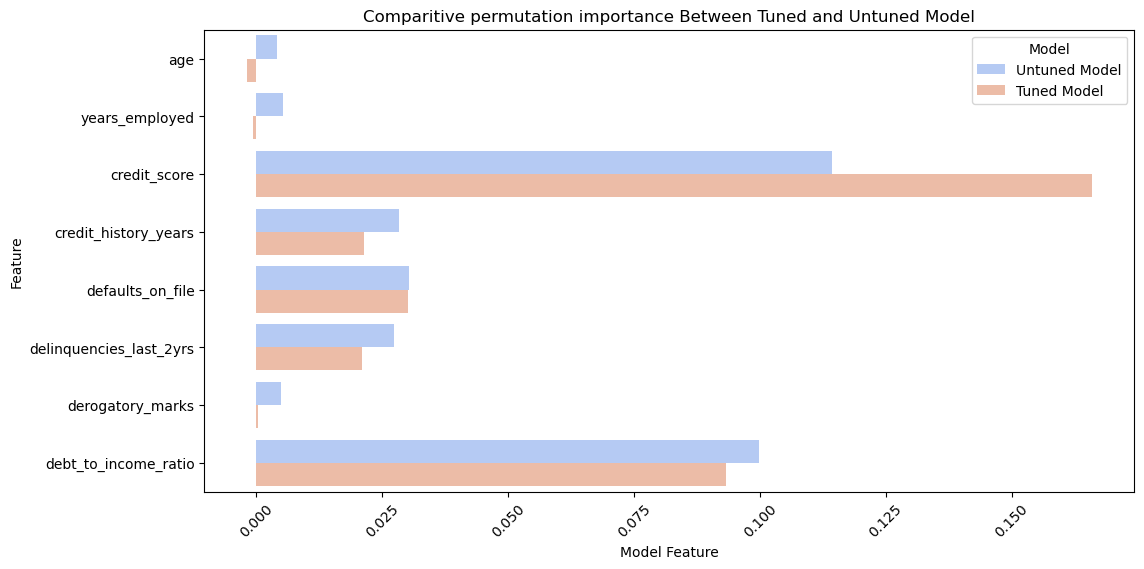

In [52]:
df_perm_long = df_perm.melt(
    id_vars='Feature',
    value_vars=['Untuned Model', 'Tuned Model'],
    var_name='Model',
    value_name='Importance'
)

plt.figure(figsize=[12,6])
sns.barplot(data=df_perm_long, x='Importance', y='Feature', hue='Model', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparitive permutation importance Between Tuned and Untuned Model')
plt.xlabel('Model Feature')

## Limitations and Future Improvements

From the most simplistic perspective, the XGBoost model makes roughly four out of five correct predictions, demonstrating both a low false negative and a low false positive rate. The impact of the remaining incorrect decisions, and whether this is an acceptable margin of error, is ultimately determined by the individual or organisation seeking to leverage machine learning for credit approval or rejection. As with the deployment of any predictive analytics, the detail often lies in the business context and the implications of inaccuracy. For example, a potential one-in-five error rate carries vastly different consequences when deployed to a self-driving car deciding when to brake, compared to a supermarket predicting customer churn.

Feature gain and permutation importance demonstrate that in the context of the available feature, credit score generally has the largest impact, both in terms of boosting the models accuracy, and also predicting the correct class. Defaults on file and debt to income ratio are also in keeping with credit score for feature gain and permutation importance, with the impact being slightly less pronounced.

One key consideration arising from this project concerns the use of synthesised data. Although the data utilised in this model is generated in line with real-world credit data, it is unlikely that actual credit application data would be as clean as the synthesised dataset. In reality, real-world credit data is likely to contain inconsistencies, missing values, and incorrectly entered information. The flexibility required to identify and manage such data quality issues would need to be built into a full production pipeline, which is beyond the scope of this project.

Another potential limitation of the XGBoost model used in this project lies in the approach to addressing class imbalance. Although a common method for handling imbalance is to apply a resampling technique, it is possible that oversampling the minority class to match the majority may obscure genuine patterns within the data, potentially resulting in reduced generalisation performance.

As previously mentioned, further improvements in model performance could be achieved by introducing additional meaningful features. However, while feature expansion may improve predictive capability in theory, it also increases model complexity. Given that XGBoost is already a highly expressive algorithm, introducing excessive or noisy features may increase the risk of overfitting.

Beyond the scope of this project, a fundamental risk to consider following deployment is the possibility of data drift. This occurs when the statistical properties of incoming data change over time, causing the patterns learned from historical data to become less representative of current conditions. This risk is particularly prevalent within the financial domain, where factors such as average income, debt levels, and employment patterns can change significantly over time. If the model is trained on outdated data, its predictions may also become outdated. As such, any live deployment of the XGBoost model would require continual performance monitoring and periodic retraining to mitigate the impact of data drift.

In summary, the XGBoost model demonstrates a more than adequate level of performance across all evaluation metrics commonly used for supervised classification tasks. While further improvements may be achievable through feature expansion, the model’s current hyperparameters appear well-optimised. Introducing additional noise into the dataset, such as records with poorer data quality, may provide valuable insight into how the model performs under more realistic conditions and allow for the exploration of techniques to improve robustness. Should the model be selected for live deployment, a stringent monitoring strategy would be essential to ensure sustained performance over time.   